# Qualitative Comparison of Baseline and CP T-Revision on CIFAR10N

In [1]:
import torch
import torchshow
import torchmetrics
from torch.nn import CrossEntropyLoss


from cp_t_revision.data_modules import CIFARNDataModule
from cp_t_revision.models import ModelModule, RevisionModelModule
from cp_t_revision.models import ResNet

/home/ubuntu/cp_t_revision/.pixi/envs/dev/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = CIFARNDataModule(noise_type="aggre_label", data_dir="/home/ubuntu/cp_t_revision/src/cp_t_revision/cifar_n", noise_path="/home/ubuntu/cp_t_revision/src/cp_t_revision/cifar_n/CIFAR-10_human.pt", batch_size=16)
data.setup()

Files already downloaded and verified
Loaded aggre_label from /home/ubuntu/cp_t_revision/src/cp_t_revision/cifar_n/CIFAR-10_human.pt.
The overall noise rate is 0.09009999999999996
noisy labels loaded from /home/ubuntu/cp_t_revision/src/cp_t_revision/cifar_n/CIFAR-10_human.pt
The noisy data ratio in each class is [0.10628 0.11018 0.10814 0.09242 0.08698 0.09926 0.09232 0.10006 0.10694
 0.09742]
over all noise rate is  0.0901


/home/ubuntu/cp_t_revision/src/cp_t_revision/cifar_n/cifar.py:136: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  noise_label = torch.load(self.noise_path)


In [3]:
loss = CrossEntropyLoss()
metrics = torchmetrics.MetricCollection([torchmetrics.Accuracy(task="multiclass", num_classes=10)])
opt = {"optimizer": "SGD", "args": {"lr": 0.001, "momentum": 0.9, "weight_decay": 0.0001}}

# Create separate model instances for each module
baseline_model_instance = ResNet(n_classes=10, resnet_type="resnet18", weights=None)
cp_t_revision_model_instance = ResNet(n_classes=10, resnet_type="resnet18", weights=None)

# Load the baseline model checkpoint
baseline_model = ModelModule.load_from_checkpoint(
    checkpoint_path="/home/ubuntu/cp_t_revision/lightning_logs/CIFAR10NDataModule_ResNet_aggre_label/version_3/checkpoints/epoch=199-step=250000.ckpt",
    model=baseline_model_instance,
    loss=loss,
    metric_collection=metrics,
    optimizer_cfg=opt
)

# Load the CP T-Revision model checkpoint
cp_t_revision_model = RevisionModelModule.load_from_checkpoint(
    checkpoint_path="/home/ubuntu/cp_t_revision/lightning_logs/CIFAR10NDataModule_ResNet_aggre_label_cp_revision_k3/version_4/checkpoints/epoch=49-step=62500.ckpt",
    model=cp_t_revision_model_instance,
    loss=loss,
    metric_collection=metrics,
    optimizer_cfg=opt
)

In [4]:
def compare_model_weights(model1, model2):
    for (name1, param1), (name2, param2) in zip(model1.model.named_parameters(), model2.model.named_parameters()):
        if name1 != name2 or not torch.equal(param1.data, param2.data):
            return False
    return True

weights_equal = compare_model_weights(baseline_model, cp_t_revision_model)
print("Weights are equal:", weights_equal)

Weights are equal: False


In [5]:
device = next(baseline_model.parameters()).device
mismatchs = []
for sample in data.test:
    input, target, *_ = sample
    input = input.to(device).unsqueeze(0)
    baseline_pred = torch.argmax(baseline_model(input), dim=1)
    cp_t_revision_pred = torch.argmax(cp_t_revision_model(input), dim=1)
    if baseline_pred != cp_t_revision_pred and cp_t_revision_pred == target:
        mismatchs.append((input.cpu(), target, baseline_pred.cpu().item(), cp_t_revision_pred.cpu().item()))


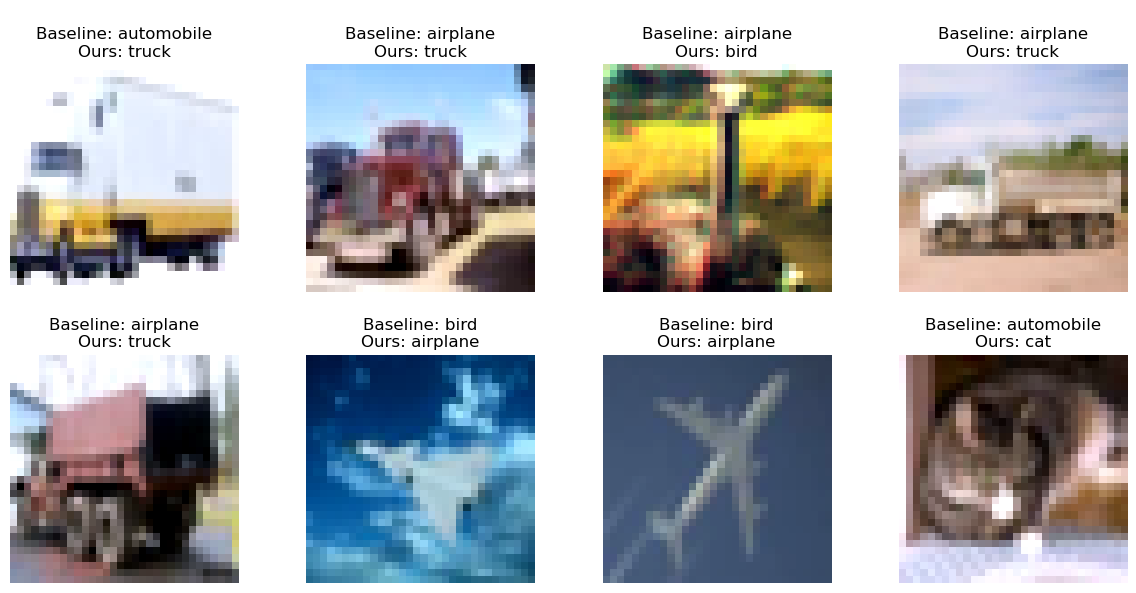

In [9]:
import matplotlib.pyplot as plt
import random

label_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

# Function to undo normalization
def undo_normalization(img, mean, std):
    mean = torch.tensor(mean).view(1, 1, -1)
    std = torch.tensor(std).view(1, 1, -1)
    return img * std + mean

# Randomly sample 8 images from the mismatch array
sampled_mismatches = random.sample(mismatchs, min(8, len(mismatchs)))

# Plot 8 images from the sampled mismatch array
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
mean = [0.4914, 0.4822, 0.4465]
std = [0.2470, 0.2435, 0.2616]
for i, ax in enumerate(axes.flat):
    if i < len(sampled_mismatches):
        input_img, target, baseline_pred, ours_pred = sampled_mismatches[i]
        # Undo normalization and normalize to [0, 1]
        img_to_plot = undo_normalization(input_img.squeeze().permute(1, 2, 0), mean, std).clamp(0, 1)
        ax.imshow(img_to_plot)  # Assuming input_img is in CHW format
        ax.axis('off')
        ax.set_title(f"\nBaseline: {label_names[baseline_pred]}\nOurs: {label_names[ours_pred]}")
    else:
        ax.axis('off')

plt.tight_layout()
plt.savefig("baseline_comparison.pdf")
plt.show()